In [1]:
import numpy as np
from bitalg.visualizer.main import Visualizer
import matplotlib.pyplot as plt

x:  4.112903225806452  y:  8.717532467532468
x:  1.129032258064516  y:  6.201298701298702
x:  2.8225806451612905  y:  1.655844155844156
x:  8.528225806451612  y:  1.8452380952380953
x:  8.991935483870968  y:  7.878787878787879
x:  6.733870967741934  y:  3.2521645021645025
x:  7.076612903225806  y:  6.120129870129871
x:  4.69758064516129  y:  6.742424242424244
x:  3.3467741935483875  y:  4.983766233766234
x:  4.05241935483871  y:  3.1439393939393945


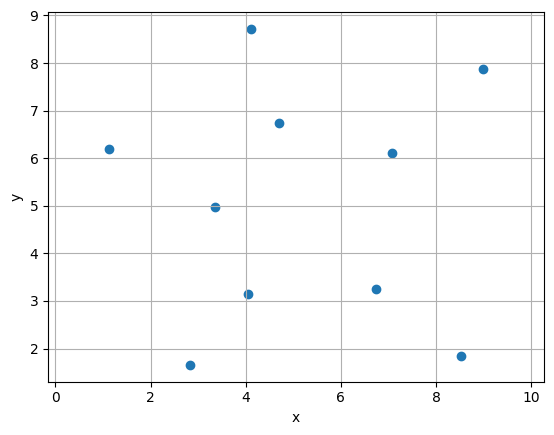

In [2]:
%matplotlib tk
from matplotlib.backend_bases import MouseButton
'''
Cała ta funkcja umożliwia zadawanie wierzchołków z myszki.
Po uruchomieniu kodu, włączy się okno, na którym należy klikać lewym przyciskiem myszy
w miejsca, w których chcemy, aby były nasze kolejne wierzchołki. Istnieje możliwość zapisania
figury, jeśli klikniemy w lewym dolnym rogu na ikonkę zapisu.
'''
points = []

fig, ax = plt.subplots()
ax.set_title('Polygon')
plt.xlim(0, 10)
plt.ylim(0, 10)

def on_click(event):
    if event.button is MouseButton.LEFT:
        x = event.xdata
        y = event.ydata
        points.append((x, y))
        ax.plot(*points[-1], marker='.', color='blue')
        plt.show()

plt.connect('button_press_event', on_click)
plt.show(block=True)
for x, y in points:
    print("x: ", x, " y: ", y)


%matplotlib inline
vis = Visualizer()
vis.add_point(points)
vis.add_grid()
vis.axis_equal()
vis.show()

In [3]:
def get_circle_coord(theta, x_center, y_center, radius):
    x = radius * np.cos(theta) + x_center
    y = radius * np.sin(theta) + y_center
    return (x,y)

def get_star_coords(n, x_center=0, y_center=0, radius=10):
    result = [get_circle_coord(i/n*2*np.pi, x_center, y_center, radius) if i%2==0 else get_circle_coord(i/n*2*np.pi, x_center, y_center, radius/2) for i in range(n)]
    return result

def get_random_coords(n, x_center=0, y_center=0, radius_max=1):
    phi = []
    while len(phi) < n:
        x = np.random.uniform(x_center - radius_max, x_center + radius_max)
        y = np.random.uniform(y_center - radius_max, y_center + radius_max)
        phi.append((x, y))
    return phi

def get_wavy_coords(n, amplitude=1, frequency=1, start_x=0, end_x=10, height=10):
    step = abs(start_x-end_x)/n
    result = [(start_x+i*step, amplitude*np.cos(frequency*(start_x+i*step))) for i in range(n)]
    for i in range(n):
        result.append((end_x-i*step, amplitude*np.cos(frequency*(end_x-i*step))+height))
    return result



In [4]:
def is_in_triangle(p, p1, p2, p3, eps=0): # funkcja sprawdza, czy dany punkt p znajduje się w środku trójkąta
        def sign(p1, p2, p3):
            return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
        
        d1 = sign(p, p1, p2)
        d2 = sign(p, p2, p3)
        d3 = sign(p, p3, p1)

        has_neg = (d1 < -eps) or (d2 < -eps) or (d3 < -eps)
        has_pos = (d1 > eps) or (d2 > eps) or (d3 > eps)
        
        return not (has_neg and has_pos)


In [5]:
def find_triangle(p, T): # funkcja znajduje trójkąt, we wnętrzu którego jest dany punkt
    for i in range (len(T)):
        p1, p2, p3 = T[i]
        if is_in_triangle(p, p1, p2, p3):
            return T[i], i

In [6]:
def on_triangle_edge(p, t, epsilon=1e-9): # funkcja sprawdza, czy punkt jest na krawędzi trójkąta, zakładamy, że punkt nie może być poza trójkątem
    p1, p2, p3 = t

    def point_on_line(p, a, b, epsilon):
        cross_product = (p[1] - a[1]) * (b[0] - a[0]) - (p[0] - a[0]) * (b[1] - a[1])
        if abs(cross_product) > epsilon:
            return False
        return True
        
    return (
        point_on_line(p, p1, p2, epsilon) or
        point_on_line(p, p2, p3, epsilon) or
        point_on_line(p, p3, p1, epsilon)
    )

In [7]:
def on_which_edge(P, A, B, C, eps=1e-5): # funkcja sprawdza, na której krawędzi trójkąta znajduje się punkt, 2 pierwsze elementy wyniku to 2 wierzcholki tej krawędzi
    def is_on_edge(P, X, Y):
        cross_product = (P[0] - X[0]) * (Y[1] - X[1]) - (P[1] - X[1]) * (Y[0] - X[0])
        if abs(cross_product) > eps: 
            return False
        
        dot_product = (P[0] - X[0]) * (Y[0] - X[0]) + (P[1] - X[1]) * (Y[1] - X[1])
        squared_length = (Y[0] - X[0]) ** 2 + (Y[1] - X[1]) ** 2
        return 0 <= dot_product <= squared_length
    
    if is_on_edge(P, A, B):
        return A, B, C
    elif is_on_edge(P, B, C):
        return B, C, A
    elif is_on_edge(P, C, A):
        return C, A, B
    else:
        raise ValueError("Punkt P nie leży na żadnej krawędzi, co nie powinno się zdarzyć.")

In [8]:
def find_triangle_with_edge(p, edge, T): # funkcja znajduje drugi trójkąt w triangulacji zawierający krawędź edge
    A, B = edge
    n = len(T)
    for i in range(n):
        triangle = T[i]
        if A in triangle and B in triangle and p not in triangle:
            remaining_point = next(pt for pt in triangle if pt not in edge)
            return T[i], i, remaining_point


In [9]:
def min_angle(A, B, C): # funkcja oblicza minimalny kąt trójkąta
    def length_squared(P, Q):
        return (P[0] - Q[0])**2 + (P[1] - Q[1])**2
    
    def angle(opposite, side1, side2):
        return np.acos((side1 + side2 - opposite) / (2 * np.sqrt(side1) * np.sqrt(side2)))
    
    a2 = length_squared(B, C)
    b2 = length_squared(A, C)
    c2 = length_squared(A, B)

    angle_A = angle(a2, b2, c2)
    angle_B = angle(b2, a2, c2)
    angle_C = angle(c2, a2, b2)

    return min(angle_A, angle_B, angle_C)

In [10]:
def is_concave(A, B, C, D):
    
    return is_in_triangle(A, B, C, D) or is_in_triangle(B, A, C, D) or is_in_triangle(C, B, A, D) or is_in_triangle(D, B, C, A)

# Example usage
A = (0, 0)
B = (2, 0)
C = (1, 1)
D = (1, -1)

print(is_concave(A, B, C, D))  # Output: True or False 


print(is_concave((4,3),(0,0),(2,0),(2,1)))

False
True


In [11]:
def is_illegal(p, edge, r, dummy): # funkcja sprawdza, czy krawędź edge wraz z punktem p jest nielegalna
    A, B = edge

    if is_concave(p, edge[0], edge[1], r):
        return False
    
    if A in dummy and B in dummy:
        return False
    
    in_dummy = 0
    for point in [A, B, p, r]:
        if point in dummy:
            in_dummy += 1

    if in_dummy == 1:
        if A in dummy or B in dummy:
            return True
        return False
    
    elif in_dummy == 2:

        if A in dummy:
            i_edge = dummy.index(A)
        elif B in dummy:
            i_edge = dummy.index(B)

        if p in dummy:
            i_pr = dummy.index(p)
        elif r in dummy:
            i_pr = dummy.index(r)

        if i_edge > i_pr:
            return False
        return True


    if min(min_angle(A, B, p), min_angle(A, B, r)) < min(min_angle(A, p, r), min_angle(B, p, r)):
        return True
    
    return False

d = []

In [12]:
def remove_triangle(triangle, T):
    A, B, C = triangle
    for t in T:
        if A in t and B in t and C in t:
            T.remove(t)

def remove_edge(edge, E):
    A, B = edge
    for e in E:
        if A in e and B in e:
            E.remove(e)

In [13]:
def legalize_edge(p, edge, T, res, dummy):

    if find_triangle_with_edge(p, edge, T) is not None:
        triangle, index, r = find_triangle_with_edge(p, edge, T)

        if is_illegal(p, edge, r, dummy):
            remove_triangle(triangle, T)
            remove_triangle((p, edge[0], edge[1]), T)
            T.append((p, r, edge[0]))
            T.append((p, r, edge[1]))
            remove_edge(edge, res)
            res.append((p, r))
            legalize_edge(p, (edge[0], r), T, res, dummy)
            legalize_edge(p, (r, edge[1]), T, res, dummy)


[((2, 0), (4, 0)), ((3, 0), (2, 0)), ((3, 0), (4, 0)), ((1, 0), (2, 0)), ((2.5, 1), (3, 0)), ((2.5, 1), (2, 0)), ((2.5, 1), (1, 0)), ((2.5, 1), (4, 0))]


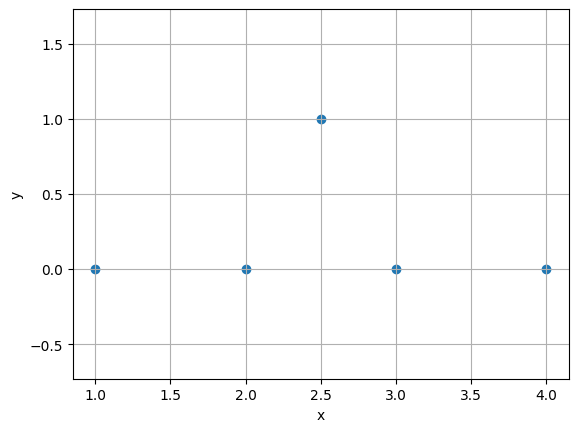

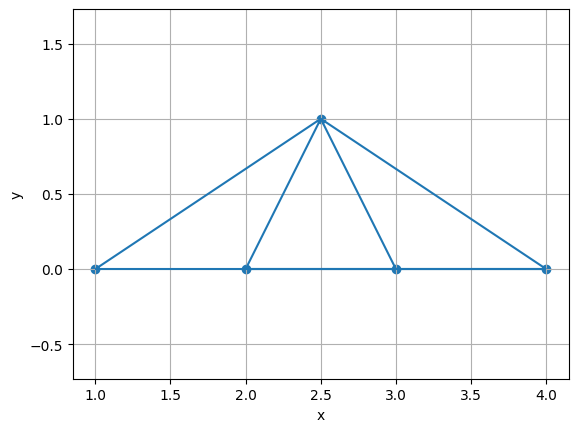

In [14]:
def delaunay(P): # P - zbior zawierajacy n punktow na plaszczyznie w postaci krotek (x,y). Zwraca tablicę dodanych przekątnych oraz tablicę stworzonych trójkątów
    P = list(set(P))
    n = len(P) 

    if n < 3:
        return
    
    if n == 3:
        return [(P[0], P[1]), (P[1], P[2]), (P[2], P[0])], [(P[0], P[1], P[2])]
    
    coord_max = max(abs(coord) for point in P for coord in point)
    
    p1 = (3*coord_max + 10, 0)
    p2 = (0, 3*coord_max + 4)
    p3 = (-3*coord_max - 5, -3*coord_max - 3)
    T = [(p1,p2,p3)]
    dummy = [p1,p2,p3]
    res = [(p1,p2),(p2,p3),(p1,p3)]

    for i in range(n):

        curr_tr, curr_tr_index = find_triangle(P[i], T)
        
        if on_triangle_edge(P[i], curr_tr):
            pi, pj, pk = curr_tr
            pi, pj, pk = on_which_edge(P[i], pi, pj, pk)

            res.append((P[i], pi))
            res.append((P[i], pj))
            res.append((P[i], pk))

            remove_triangle(curr_tr, T)
            T.append((P[i], pi, pj))
            T.append((P[i], pj, pk))
            T.append((P[i], pi, pk))

            legalize_edge(P[i], (pi, pj), T, res, dummy)

            legalize_edge(P[i], (pj, pk), T, res, dummy)

            legalize_edge(P[i], (pi, pk), T, res, dummy)
            
            if find_triangle_with_edge(P[i], (pi, pj), T) is not None:
                triangle, index, r = find_triangle_with_edge(P[i], (pi,pj), T)

                legalize_edge(P[i], (pi, r), T, res, dummy)
                legalize_edge(P[i], (r, pj), T, res, dummy)

            
        else:
            pi, pj, pk = curr_tr
            res.append((P[i], pi))
            res.append((P[i], pj))
            res.append((P[i], pk))

            remove_triangle(curr_tr, T)
            T.append((P[i], pi, pj))
            T.append((P[i], pj, pk))
            T.append((P[i], pi, pk))

            legalize_edge(P[i], (pi, pj), T, res, dummy)

            legalize_edge(P[i], (pj, pk), T, res, dummy)

            legalize_edge(P[i], (pi, pk), T, res, dummy)
    
    T = [triangle for triangle in T if not (p1 in triangle or p2 in triangle or p3 in triangle)]
    res = [edge for edge in res if not (p1 in edge or p2 in edge or p3 in edge)]


    return res, T
P = [(1,0),(2,0),(3,0),(4,0),(2.5,1)]
V = Visualizer()
V.add_grid()
V.axis_equal()
V.add_point(P)
V.show()
edges, triangles = delaunay(P)
print(edges)
V.add_line_segment(edges)
V.show()



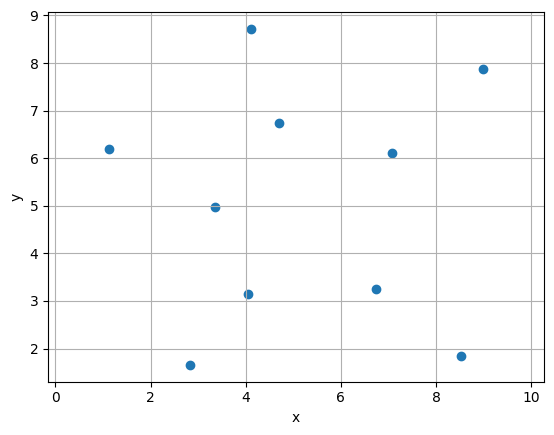

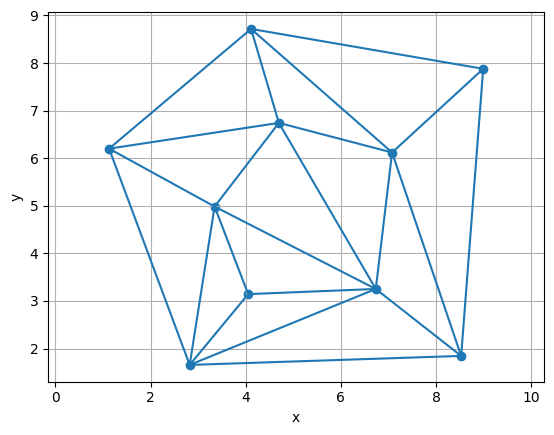

In [15]:
# Punkty wygenerowane myszką

P = points
V = Visualizer()
V.add_grid()
V.axis_equal()
V.add_point(P)
V.show()
edges, triangles = delaunay(P)
V.add_line_segment(edges)
V.show()

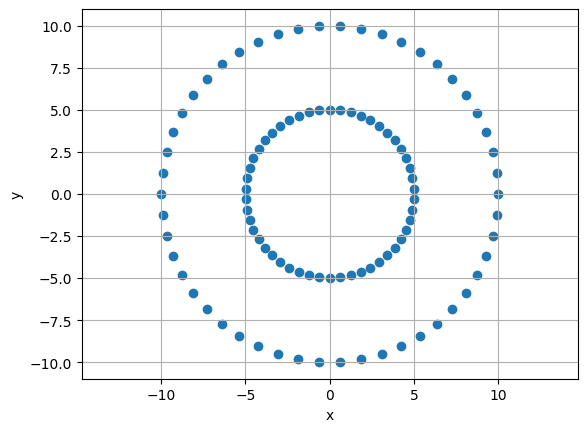

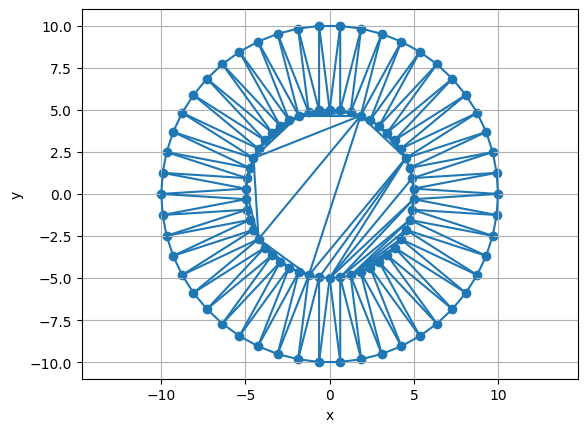

In [16]:
# Star coords

P = get_star_coords(100)
V = Visualizer()
V.add_grid()
V.axis_equal()
V.add_point(P)
V.show()
edges, triangles = delaunay(P)
V.add_line_segment(edges)
V.show()

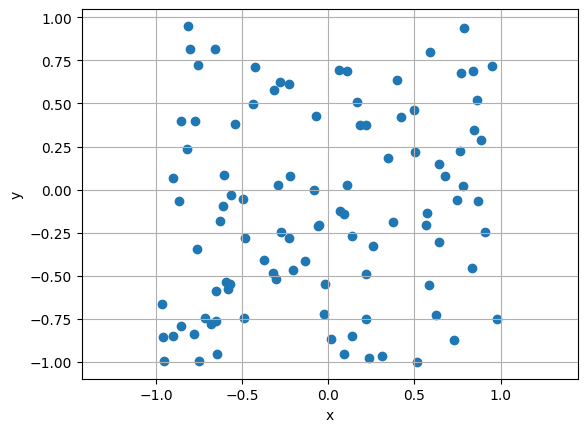

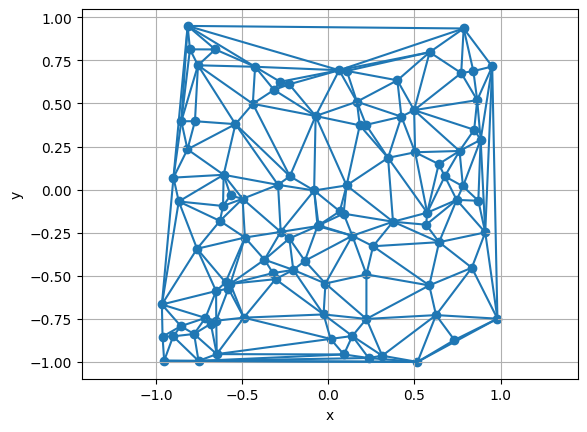

In [17]:
# Random coords

P = get_random_coords(100)
V = Visualizer()
V.add_grid()
V.axis_equal()
V.add_point(P)
V.show()
edges, triangles = delaunay(P)
V.add_line_segment(edges)
V.show()

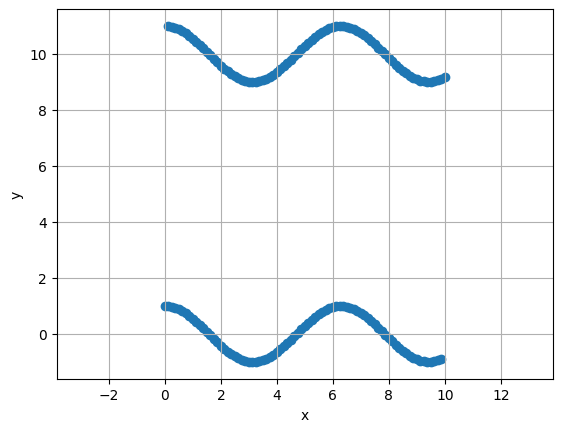

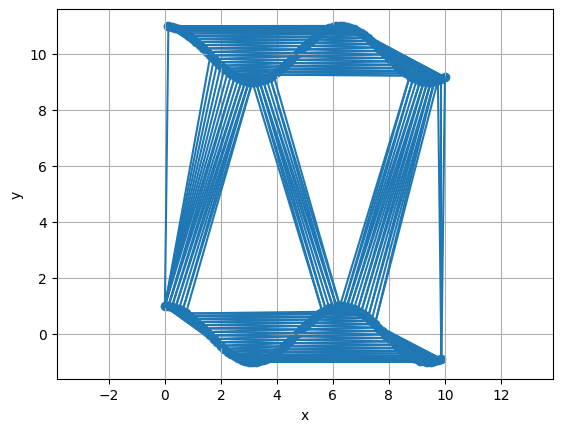

In [18]:
# Wavy coords

P = get_wavy_coords(80)
V = Visualizer()
V.add_grid()
V.axis_equal()
V.add_point(P)
V.show()
edges, triangles = delaunay(P)
V.add_line_segment(edges)
V.show()

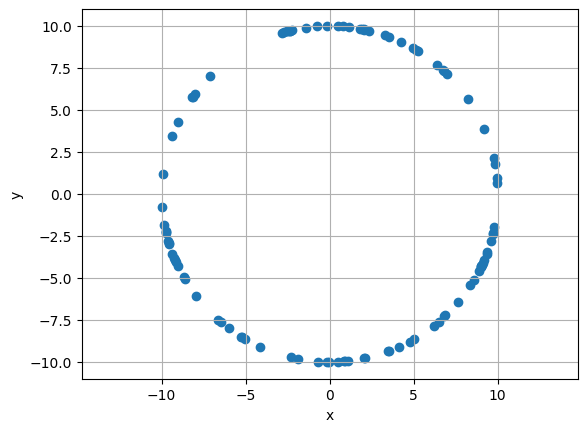

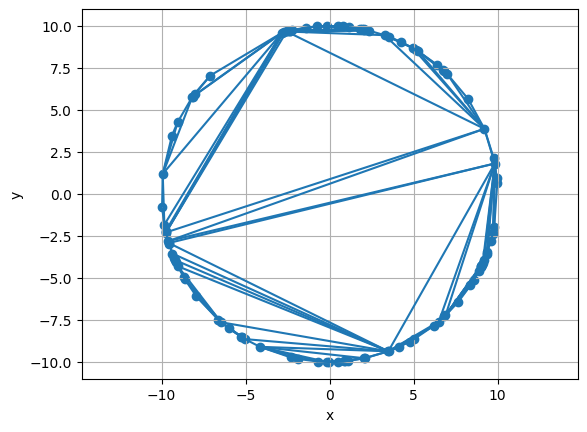

In [19]:
import math

def generate_circle_points(O=(0,0), R=10, n=100):
    """
    Funkcja generuje jednostajnie n punktów na okręgu o środku O i promieniu R
    :param O: krotka współrzędnych x, y określająca środek okręgu
    :param R: promień okręgu
    :param n: ilość generowanych punktów
    :return: tablica punktów w postaci krotek współrzędnych
    """
    res = []
    for _ in range(n):
        t = np.random.uniform(0, 2 * math.pi)
        x = R * math.cos(t) + O[0]
        y = R * math.sin(t) + O[1]
        res.append((x,y))
    return res

P = generate_circle_points()
V = Visualizer()
V.add_grid()
V.axis_equal()
V.add_point(P)
V.show()
edges, triangles = delaunay(P)
V.add_line_segment(edges)
V.show()


C:\Users\mateu\AppData\Local\Temp\ipykernel_15340\368207971.py:6: RuntimeWarning: invalid value encountered in arccos
  return np.acos((side1 + side2 - opposite) / (2 * np.sqrt(side1) * np.sqrt(side2)))


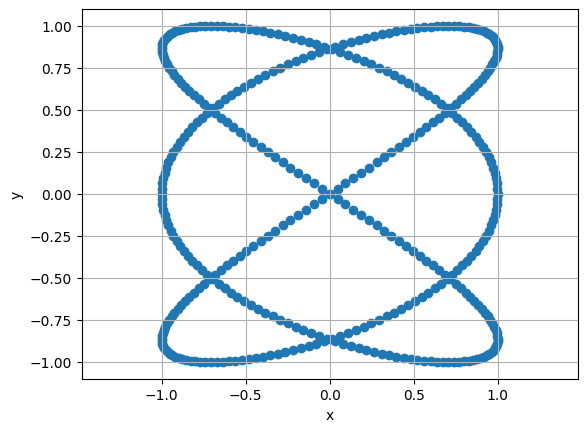

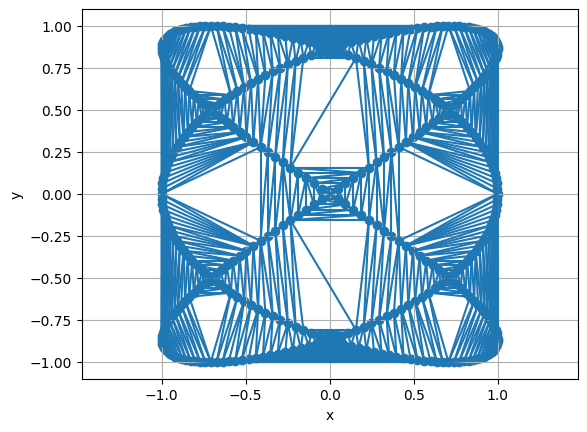

In [20]:
def generate_lissajous_points(n, a=3, b=2, delta=np.pi / 2):
    """
    Generate equally spaced points for a Lissajous curve.

    Parameters:
    n (int): Number of points to generate.
    a (int): Frequency of the x-axis oscillation.
    b (int): Frequency of the y-axis oscillation.
    delta (float): Phase difference between x and y.

    Returns:
    list of tuples: The (x, y) coordinates of the Lissajous curve points.
    """
    t = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x = np.sin(a * t + delta)
    y = np.sin(b * t)
    return [(xi, yi) for xi, yi in zip(x, y)]

coordinates = generate_lissajous_points(400)
V = Visualizer()
V.add_grid()
V.axis_equal()
V.add_point(coordinates)
V.show()
edges, triangles = delaunay(coordinates)
V.add_line_segment(edges)
V.show()